<a href="https://colab.research.google.com/github/yaniv92648/OpenU_DL/blob/main/OpenU_DL_Maman_12_Optimization_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

לינק להקלטה

https://drive.google.com/file/d/1kf9IojSM1GjeSgBg3c0dcrf_nXZ6BG1w/view?usp=sharing


תיקונים קלים להקלטה:

שאלה 2, סעיפים ד,ה:

הפונקציה שמאפסת חצי מכל דגימה של הקלט כעת מאפסת בדיוק את אותם מאפיינים בכל דגימה, בניגוד לקודם.

הפונקציה שמחשבת ממוצע ושונות כעת לא סתם בודקת איפה בקלט אין אפס, אלא היא בודקת איפה במסיכה אין אפס.

שכבת הנירמול במודל של פייטורצ' הומרה מבאץ' נורם ללייר נורם.

In [ ]:
import torch
import numpy as np
import seaborn as sns
from torch import nn, from_numpy, tensor, optim
import torchvision
from time import time
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
from torch.distributions.uniform import Uniform
from google.colab import drive

# 1 - א + ב

In [ ]:
class SplitLinear():

  def __init__(self, X, M):
    N = len(X) // M
    self.samples = X.view(N, M)
    linear = nn.Linear(M//2, 1)
    linear.reset_parameters() # Question 1 ב
    self.model = nn.Sequential(linear, nn.ReLU())

  def forward(self):
    samples_1, samples_2 = torch.split(self.samples, 2, dim=1)
    return torch.cat([self.model(samples_1), self.model(samples_2)])

# 1 - ב

באתחול קבוע וזהה לכל המשקלים, כל הנוירונים בשכבה יבצעו את אותו החישוב, ובפעפוע של השגיאה לאחור, הגרדיאנט אשר יחושב עבור פרמטרים אלו גם הוא יהיה זהה.

לפיכך, הגדלת מספר הנוירונים לא תגדיל את יכולת החישוב של השכבה שלנו, ולמעשה היא תהיה שקולה לשכבה עם נוירון אחד.

על כן, אנו רוצים "לשבור את הסימטריה" ובעצם להגדיל את האנטרופיה במערכת שלנו.

ולכן, אתחול סביר של פרמטרי השכבה הוא אתחול אקראי (כדי שכל נוירון יבצע חישוב אחר) לערכים באותו סדר גודל, כך שככל שיש יותר משתני קלט/פלט - הפרמטרים יאותחלו עם שונות קטנה יותר.

השיקולים הנ"ל נלקחו בחשבון בפונקציה 

reset_parameters()

# 1 - ג

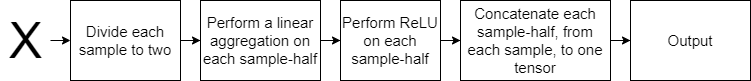

# 1 - ד

ראשית, אנו מפצלים את הטנסורים ואין פה למידה של משקולות.

שנית, כל חצי עובר דרך השכבה הלינארית עם אותם המשקלים, ולכן יש פה תהליך למידה של המשקולות.

שלישית, אנו מבצעים רליו ואין פה תהליך למידה של משקולות.

מספר הפרמטרים הוא לכן

M/2.

# 1 ה

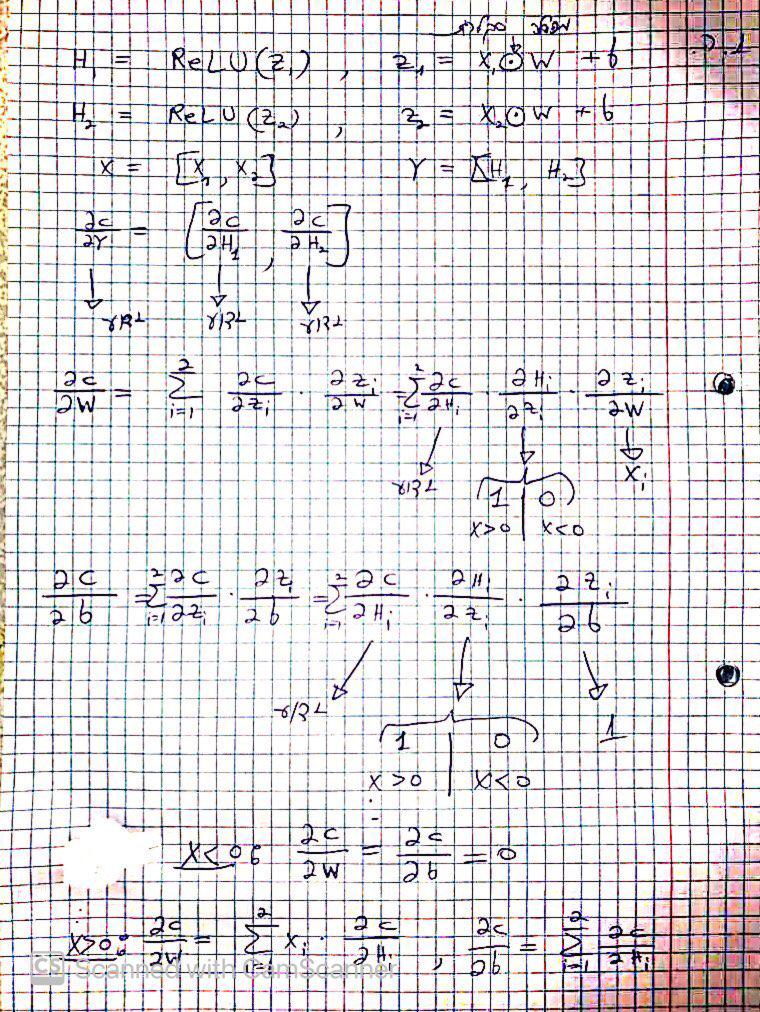

# 1 - ו

במקרה הזה יהיו רבע

M

משקלים, והאינדקס של הסיגמא ימשיך עד 4 במקום רק עד 2

# 2 - א + ב

In [ ]:
class DropNorm(nn.Module):
  
  def __init__(self, in_features):
    super().__init__()
    self.gamma = nn.Parameter(torch.ones(in_features))
    self.beta = nn.Parameter(torch.zeros(in_features))

  def zero_half_of_tensor(self, X):
    dim_0, dim_1 = X.shape[0], X.shape[1]
    random_indices = torch.randperm(dim_1)
    zeroed_indices = random_indices[:(dim_1//2)]
    mask = torch.ones(dim_1)
    mask[zeroed_indices] = 0
    mask = mask.expand_as(X)
    return X * mask, mask

  def calculate_mu_sigma_squared(self, X, dropout_mask):
    mu = (X.sum(dim=1) / dropout_mask.sum(dim=1))[:, None]
    X_meaned = torch.where(dropout_mask != 0, X - mu, X)
    sigma_squared = (X_meaned.square().sum(dim=1) / dropout_mask.sum(dim=1))[:, None]
    return X_meaned, sigma_squared

  def forward(self, X):
    X = X.flatten(start_dim=1) # Flat to 2 dimensions
    if self.training:
      # Dropout
      X, dropout_mask = self.zero_half_of_tensor(X)
    # Normalization
    X_meaned, sigma_squared = self.calculate_mu_sigma_squared(X, dropout_mask)
    epsilon = 10**(-5)
    x_hat = X_meaned / torch.sqrt(sigma_squared + epsilon)
    return self.gamma * x_hat + self.beta

# 2 - ב

1. אנחנו משטחים את הקלט ל-2 מימדים
2. אנחנו מאפסים רק בתהליך האימון חצי מהקלט כי איננו רוצים להרוס את התחזיות שלנו
3. אנחנו מנרמלים כל דגימה בנפרד
4. אנחנו לומדים את הפרמטרים גאמא ובטא

# 2 ג

אתחול גאמא ובטא בדרך הנ"ל הוא כדי שהפלט של השכבה יהיה בהתאם להתפלגות סטנדרטית, כך אנו מתחילים מ"נקודה התחלה מנורמלת" ואז בתהליך הלמידה - גאמא ובטא יתעדכנו ויגרמו להזזה וניפוח (הכפלה) טובים יותר של ההתפלגות.

Question 2 ד + ה

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model_FashionMNIST(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  transform =  Compose([torchvision.transforms.ToTensor()])
  train_set = FashionMNIST(root='./data/FashionMNIST', train=True, download=True, transform=transform)
  train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
  for epoch in range(1, 10):
    correct, total = 0, 0
    for images, labels in train_loader:
      images = images.view(images.shape[0], -1)
      outputs = model(images)
      predictions = torch.max(outputs, 1)[1]
      loss = criterion(outputs, labels)
      # PyTorch by default accumulates the gradients on subsequent backward passes on "loss.backward()" (which is good for RNN, for example).
      # Because of this, we should zero out the gradients so that we do the parameter update correctly. 
      # Otherwise, the gradient would be a combination of the old gradient, which we've already used to update our model parameters, 
      # and the newly-computed gradient, causing the direction to be less optimal.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      correct += (predictions == labels).sum()
      total += len(labels)
    else:
      print(f'{epoch}. Training Accuracy: {correct / total}')

In [ ]:
def test_model_FashionMNIST(model):
  transform =  Compose([torchvision.transforms.ToTensor()])
  test_set = FashionMNIST(root='./data/FashionMNIST', train=False, download=True, transform=transform)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
  correct, total = 0, 0
  for images, labels in test_loader:
    images = images.view(images.shape[0], -1)
    outputs = model(images)
    predictions = torch.max(outputs, 1)[1]
    correct += (predictions == labels).sum()
    total += len(labels)
  else:
    print(f'Test Accuracy: {correct / total}')

In [ ]:
cp_model = nn.Sequential(nn.Linear(784, 32),
                         nn.Dropout(),
                         nn.LayerNorm(32),
                         nn.Linear(32, 10))

user_model = nn.Sequential(nn.Linear(784, 32),
                           DropNorm(in_features=32),
                           nn.Linear(32, 10))

In [ ]:
train_model_FashionMNIST(cp_model)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

1. Training Accuracy: 0.7745000123977661
2. Training Accuracy: 0.8134666681289673
3. Training Accuracy: 0.819516658782959
4. Training Accuracy: 0.8248500227928162
5. Training Accuracy: 0.8295666575431824
6. Training Accuracy: 0.8323333263397217
7. Training Accuracy: 0.8349499702453613
8. Training Accuracy: 0.8364499807357788
9. Training Accuracy: 0.8375833630561829


In [ ]:
test_model_FashionMNIST(cp_model)

Test Accuracy: 0.8216999769210815


In [ ]:
train_model_FashionMNIST(user_model)

1. Training Accuracy: 0.7649166584014893
2. Training Accuracy: 0.8062833547592163
3. Training Accuracy: 0.8183833360671997
4. Training Accuracy: 0.8233000040054321
5. Training Accuracy: 0.826033353805542
6. Training Accuracy: 0.8297666907310486
7. Training Accuracy: 0.8310666680335999
8. Training Accuracy: 0.83201664686203
9. Training Accuracy: 0.8326333165168762


In [ ]:
test_model_FashionMNIST(user_model)

Test Accuracy: 0.8264999985694885


# 2 ו

According to the above, I would prefer to use my NN because the test accuracy of user_model is higher than that of cp_model.

# 2 ז

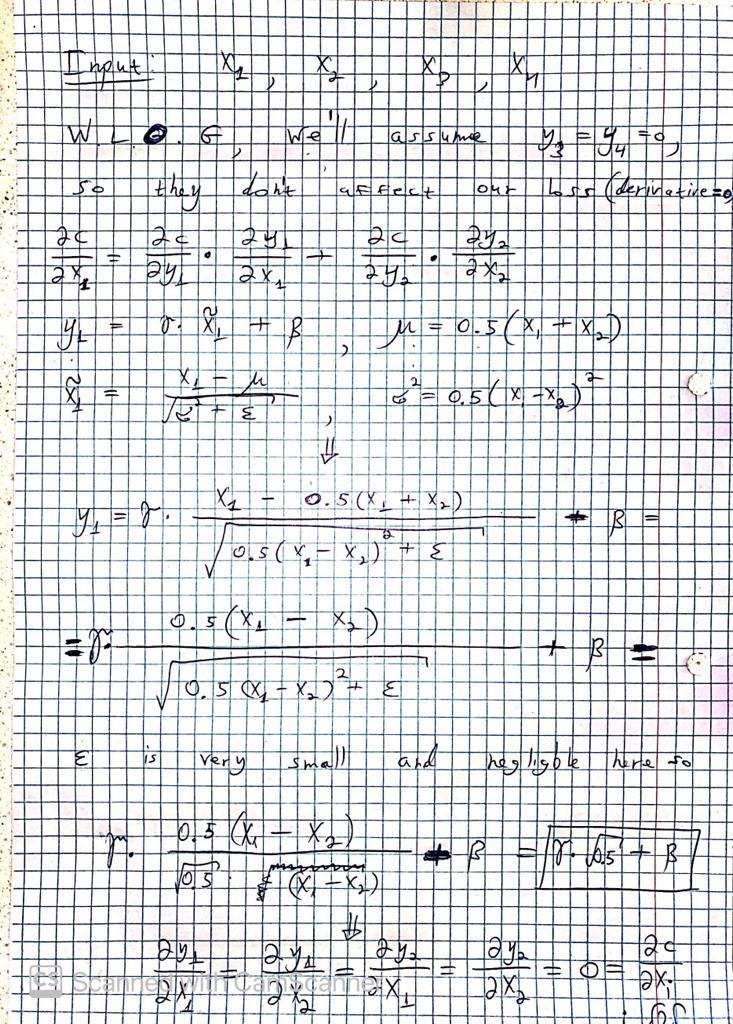

 3 א + ב + ג

In [ ]:
drive.mount('/gdrive', force_remount=True)
# Change the following path to your own Google Drive path to to the data.csv file in the diabetes folder
# Alternatively, you can also upload your diabetes.csv to here (colab) and change the PATH variable accordingly
!ln -s "/gdrive/My Drive/diabetes" "/content/diabetes"
PATH = 'diabetes/data.csv'

Mounted at /gdrive


In [ ]:
class DiabetesDataset(Dataset):

  def __init__(self):
    super().__init__()
    self.df = pd.read_csv(PATH, sep = '	')

  def __getitem__(self, index):
    return torch.tensor(list(self.df.drop(columns='Y').loc[index, :])), self.df.loc[index, 'Y']

  def __len__(self):
    return self.df.shape[0] # len(df)

In [ ]:
diabetes_dataset = DiabetesDataset()

train_size = int(0.8 * len(diabetes_dataset))
test_size = len(diabetes_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(diabetes_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

# 3 ד

In [ ]:
# One batch of 10 data points for training set
next(iter(train_loader))

[tensor([[ 53.0000,   2.0000,  22.1000,  98.0000, 165.0000, 105.2000,  47.0000,
            4.0000,   4.1589,  81.0000],
         [ 59.0000,   2.0000,  26.9000, 104.0000, 194.0000, 126.6000,  43.0000,
            5.0000,   4.8040, 106.0000],
         [ 50.0000,   1.0000,  31.9000,  78.3300, 207.0000, 149.2000,  38.0000,
            5.4500,   4.5951,  84.0000],
         [ 55.0000,   2.0000,  23.4000,  83.0000, 166.0000, 101.6000,  46.0000,
            4.0000,   4.5218,  96.0000],
         [ 73.0000,   1.0000,  27.0000, 102.0000, 211.0000, 121.0000,  67.0000,
            3.0000,   4.7449,  99.0000],
         [ 34.0000,   2.0000,  25.3000, 111.0000, 230.0000, 162.0000,  39.0000,
            6.0000,   4.9767,  90.0000],
         [ 61.0000,   1.0000,  25.8000,  90.0000, 280.0000, 195.4000,  55.0000,
            5.0000,   4.9972,  90.0000],
         [ 35.0000,   1.0000,  28.7000,  97.0000, 204.0000, 126.8000,  64.0000,
            3.0000,   4.1897,  93.0000],
         [ 48.0000,   1.0000,  3

In [ ]:
# One batch of 10 data points for test set
next(iter(test_loader))

[tensor([[ 46.0000,   1.0000,  20.6000,  73.0000, 172.0000, 107.0000,  51.0000,
            3.0000,   4.2485,  80.0000],
         [ 31.0000,   2.0000,  35.3000, 125.0000, 187.0000, 112.4000,  48.0000,
            4.0000,   4.8903, 109.0000],
         [ 24.0000,   1.0000,  22.5000,  89.0000, 141.0000,  68.0000,  52.0000,
            3.0000,   4.6540,  84.0000],
         [ 59.0000,   2.0000,  25.5000,  95.3300, 190.0000, 139.4000,  35.0000,
            5.4300,   4.3567, 117.0000],
         [ 58.0000,   2.0000,  23.6000,  96.0000, 257.0000, 171.0000,  59.0000,
            4.0000,   4.9053,  82.0000],
         [ 35.0000,   1.0000,  20.4000,  65.0000, 187.0000, 105.6000,  67.0000,
            2.7900,   4.2767,  78.0000],
         [ 52.0000,   2.0000,  19.7000,  81.0000, 152.0000,  53.4000,  82.0000,
            2.0000,   4.4188,  82.0000],
         [ 58.0000,   2.0000,  38.0000, 103.0000, 150.0000, 107.2000,  22.0000,
            7.0000,   4.6444,  98.0000],
         [ 54.0000,   2.0000,  3

# 3 ה

In [ ]:
diabetesNN = nn.Sequential(
                            nn.Flatten(),
                            nn.Linear(10, 10),
                            nn.ReLU(),
                            nn.Linear(10, 10),
                            nn.ReLU(),
                            nn.Linear(10, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(diabetesNN.parameters(), lr=0.01)
num_epochs = 100

In [ ]:
def train_model_diabetes():
  df_train_losses = pd.DataFrame(data=[[0, 0]]*num_epochs, columns=['epochs', 'losses'])
  df_train_losses['epochs'] = df_train_losses.index
  for epoch in range(num_epochs):
    losses = []
    for data in train_loader:
      # Data
      inputs, labels = data
      # Forward
      y_pred = diabetesNN(inputs)
      labels = labels[:, None].float()
      loss = criterion(y_pred, labels)
      # Backward
      optimizer.zero_grad()
      loss.backward()
      # Update
      optimizer.step()
      losses.append(int(loss.item()))
    epoch_loss = np.mean(losses)
    df_train_losses.loc[epoch, 'losses'] = epoch_loss
  sns.lineplot(data=df_train_losses, x="epochs", y="losses");

In [ ]:
def test_model_diabetes():
  losses = []
  for i, data in enumerate(test_loader):
    inputs, labels = data
    y_pred = diabetesNN(inputs)
    labels = labels[:, None].float()
    loss = criterion(y_pred, labels)
    losses.append(int(loss.item()))
  print(f'test loss = {int(np.mean(losses))}')

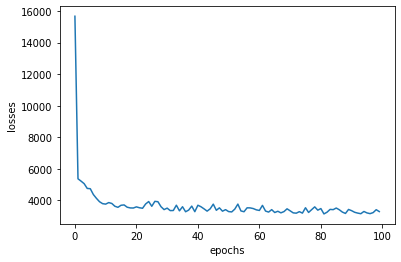

In [ ]:
train_model_diabetes()

In [ ]:
test_model_diabetes()

test loss = 2946
